# Lens modeling of DESIJ1018-0121 with `lenstronomy`
**Authors:** MD. Jobair Hasan, Anowar Shajib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## Import the required packages

In [ ]:
# make sure lenstronomy is installed, otherwise install the latest pip version

try:
  import lenstronomy
except:
  !pip install lenstronomy

try:
  import emcee
except:
  !pip install emcee

try:
  import corner
except:
  !pip install corner

try:
  import joblib
except:
  !pip install joblib


In [ ]:
#import the necessary python libraries

import h5py
import numpy as np
import matplotlib.pyplot as plt
import joblib


%matplotlib inline


## Read the data file


In [ ]:
with h5py.File('DESIJ1018-0121_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data


{'background_rms': 0.018610074701766573,
 'dec_at_xy_0': -5.799999999999994,
 'exposure_time': array([[486.32956, 387.50772, 555.4221 , ..., 561.57306, 436.89725,
         453.8047 ],
        [525.3609 , 455.32626, 433.4547 , ..., 467.7759 , 393.7413 ,
         575.8005 ],
        [406.4474 , 553.6718 , 442.7201 , ..., 439.1787 , 455.65027,
         465.92584],
        ...,
        [424.9911 , 470.85703, 480.29526, ..., 431.6869 , 500.74237,
         476.34906],
        [416.17792, 491.75076, 384.38663, ..., 364.7395 , 248.40552,
         394.68134],
        [461.31955, 487.39075, 457.4765 , ..., 516.8107 , 438.08667,
         375.04907]], dtype=float32),
 'image_data': array([[ 0.01961958, -0.00048153, -0.01787547, ..., -0.01659699,
         -0.00921571,  0.01057982],
        [ 0.02892776,  0.01651465, -0.00482212, ..., -0.00829422,
         -0.00578246,  0.0005834 ],
        [ 0.01247546,  0.00889849,  0.00884483, ...,  0.01536562,
          0.0021972 , -0.01391137],
        ...,
   

## Load the PSF data

In [ ]:
with h5py.File('psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf['psf_type'] = 'PIXEL'

kwargs_psf


{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

## Get the image data from `kwargs_data` and plot it

C:\Users\Zobai\AppData\Local\Temp\ipykernel_12112\2608440245.py:4: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
C:\Users\Zobai\AppData\Local\Temp\ipykernel_12112\2608440245.py:5: RuntimeWarning: invalid value encountered in log10
  ax2.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')


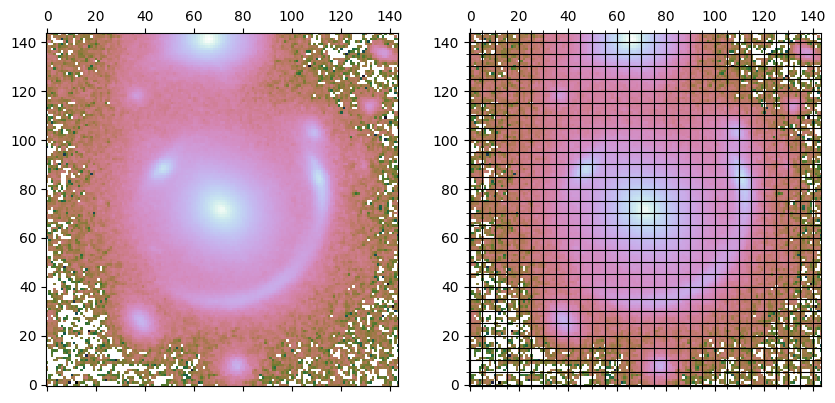

In [ ]:
image_data = kwargs_data['image_data']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
ax2.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
ax2.grid(which='both', color='black')
ax2.minorticks_on()
ax2.grid(which='minor', color='black')
plt.show()


## Make Likelihood mask and plot it

C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Zobai\AppData\Local\Temp\ipykernel_12112\478798351.py:30: RuntimeWarning: invalid value encountered in log10
  image = np.log10(image_data)


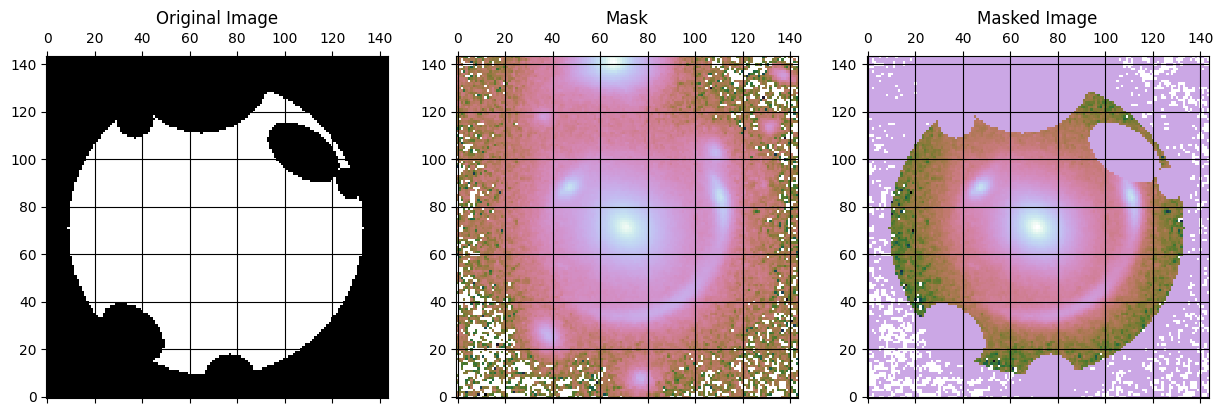

In [ ]:
import lenstronomy.Util.mask_util as mk
import lenstronomy.Util.util as ut


x_c, y_c = np.meshgrid(np.arange(144), np.arange(144))
mask = 1 - mk.mask_center_2d(71, 71, 62, x_c, y_c)

mask_params = [[65, 140, 30, 29, 0],
               #[55, 45, 2, 2, 0],
               [108, 103, 17, 10, np.pi*145/180],
               [77, 7, 11, 11, 0],
               [36, 27, 15, 10, np.pi*140/180],
               [37,117, 8, 8, 0],
               [127, 90, 7, 5, np.pi*115/180],
               #[47, 88, 10, 5, np.pi*45/180]
               ]

for mask_param in mask_params:
  mask *= 1 - mk.mask_ellipse(x_c, y_c,
                              mask_param[0],
                              mask_param[1],
                              mask_param[2],
                              mask_param[3],
                              mask_param[4]
                              )

mask[mask >= 1] = 1
mask[mask < 0] = 0

image = np.log10(image_data)
masked_image = np.multiply(image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(mask, origin='lower', cmap='gray')
ax1.grid(which='both', color='black')
ax1.grid(which='minor', color='black')
ax1.title.set_text('Original Image')
ax2.matshow(image, origin='lower', cmap='cubehelix')
ax2.grid(which='both', color='black')
ax2.grid(which='minor', color='black')
ax2.title.set_text('Mask')
ax3.matshow(masked_image, origin='lower', cmap='cubehelix')
ax3.grid(which='both', color='black')
ax3.grid(which='minor', color='black')
ax3.title.set_text('Masked Image')


## PSO: Fit the lens model with the Created Mask using `Lenstronomy`

In [ ]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
lens_light_model_list = ['SERSIC_ELLIPSE']


In [ ]:
## Visualing the PSO fit

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = [{'theta_E': 2.8781425409600296,
                     'gamma': 1.9319861694639948,
                     'e1': 0.021413200869350456,
                     'e2': 0.10359244109689184,
                     'center_x': 0.10314548733617177,
                     'center_y': -0.07645658795264434},
                    {'gamma1': 0.0172948087312718,
                     'gamma2': -0.016985761564986095,
                     'ra_0': 0.0,
                     'dec_0': 0.0}]
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

fixed_lens.append({'ra_0': 0., 'dec_0': 0.})

kwargs_lens_sigma.append({'theta_E': .2, 'gamma': .1, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.5, 'center_y': 0.5})
kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05})

kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1., 'e1': -0.5,
                          'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})

kwargs_upper_lens.append({'theta_E': 10., 'gamma': 3., 'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens,
               kwargs_lower_lens, kwargs_upper_lens]



# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = [{'amp': 1,
                           'R_sersic': 1.249301353224054,
                           'n_sersic': 4.0,
                           'e1': 0.021413200869350456,
                           'e2': 0.10359244109689184,
                           'center_x': 0.10314548733617177,
                           'center_y': -0.07645658795264434}]
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({'n_sersic': 4.})

kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05,
                                'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1,
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001,
                                'n_sersic': .5, 'center_x': -10,
                                'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10,
                                'n_sersic': 5., 'center_x': 10,
                                'center_y': 10, 'amp': 100})

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                     fixed_lens_light, kwargs_lower_lens_light,
                     kwargs_upper_lens_light]


# source galaxy's light model
fixed_source = []
kwargs_source_init = [{'amp': 1,
                       'R_sersic': 0.2243951545913847,
                       'n_sersic': 1.0,
                       'e1': 0.031446570666397305,
                       'e2': -0.08645965853676447,
                       'center_x': -0.26484686266794166,
                       'center_y': -0.21785501426367085},
                      {'amp': 1,
                       'n_max': 10,
                       'beta': 0.03157782151741702,
                       'center_x': -0.26484686266794166,
                       'center_y': -0.21785501426367085}]
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({'n_sersic': 1.})

fixed_source.append({'n_max': 10})

kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05,
                            'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2,
                            'amp': 10})
kwargs_source_sigma.append({'beta': 0.1, 'center_x': 0.1, 'center_y': 0.1})

kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001,
                            'n_sersic': .5, 'center_x': -10, 'center_y': -10,
                            'amp': 0})
kwargs_lower_source.append({'beta':0.01, 'center_x': -10, 'center_y': -10})

kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 0.4,
                            'n_sersic': 5., 'center_x': 10, 'center_y': 10,
                            'amp': 100})
kwargs_upper_source.append({'beta':5, 'center_x': 10, 'center_y': 10})

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light,
                      'joint_source_with_source': joint_source_with_source}


In [ ]:
kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask]
                     }

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }


In [ ]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                     # 'multi-linear': every imaging band has independent
                     # solutions of the surface brightness,
                     # 'joint-linear': there is one joint solution of the linear
                     # coefficients demanded across the bands.
                    }


In [ ]:
import joblib
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood,
                              kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100,
                                'n_iterations': 200}],
                       #['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
                       # 200, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)

fit_output = chain_list
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints,
              kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

output_path = f'./DESIJ1018-0121_pso_output_mini.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)

print(kwargs_result)

Computing the PSO ...
10
Max iteration reached! Stopping.
-1.2022199274284389 reduced X^2 of best position
-5929.34868207706 log likelihood
9864 effective number of data points
[{'theta_E': 2.8791944210872153, 'gamma': 1.9123338961332277, 'e1': 0.02141023947880997, 'e2': 0.10338236031338606, 'center_x': 0.10318024299174353, 'center_y': -0.07641337271624558}, {'gamma1': 0.017403457194550807, 'gamma2': -0.014496327790101028, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.2198547073280723, 'n_sersic': 1.0, 'e1': 0.03285873811300954, 'e2': -0.08944386224976253, 'center_x': -0.25720822220379513, 'center_y': -0.21476472100327648}, {'amp': 1, 'n_max': 10, 'beta': 0.030838456648300525, 'center_x': -0.25720822220379513, 'center_y': -0.21476472100327648}] source result
[{'amp': 1, 'R_sersic': 1.2494023489847377, 'n_sersic': 4.0, 'e1': 0.02141023947880997, 'e2': 0.10338236031338606, 'center_x': 0.10318024299174353, 'center_y': -0.07641337271624558}] lens light result
[] point s

## Visualize the PSO fit:

-1.1921883345887323 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.192188334588893


C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\Users\Zobai\AppData\Local\Temp\ipykernel_13484\1300959120.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


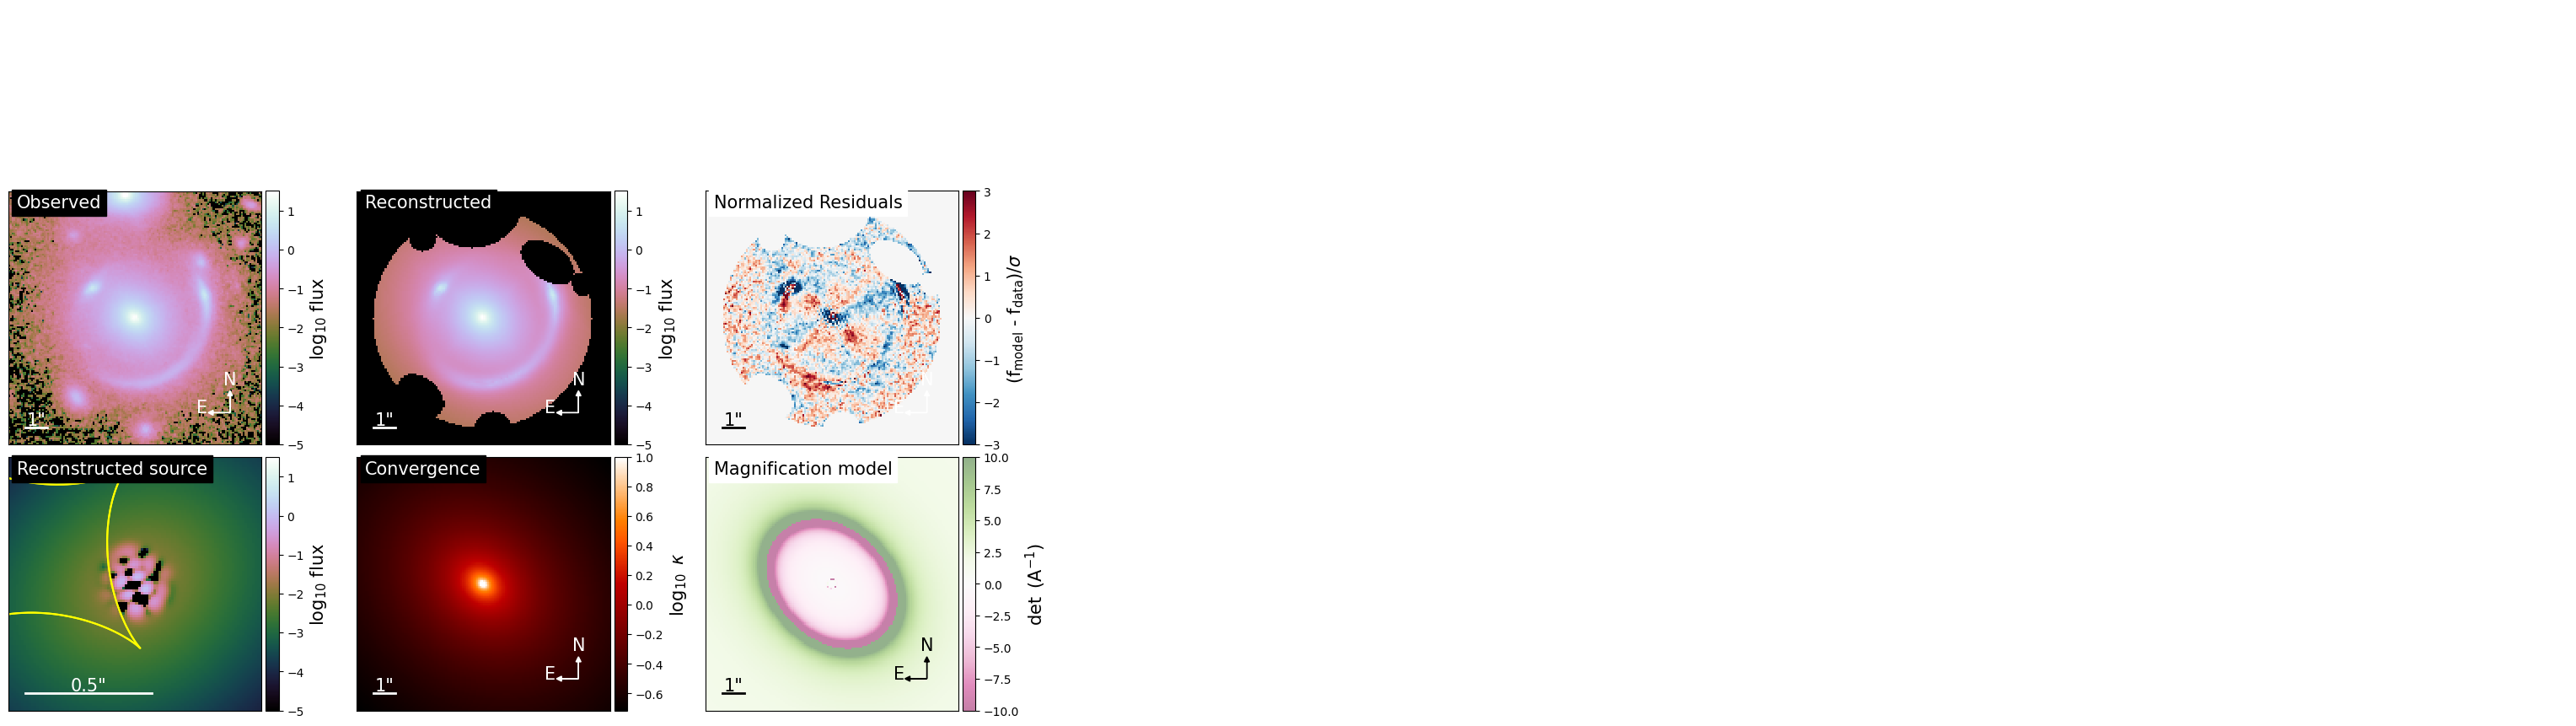

C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


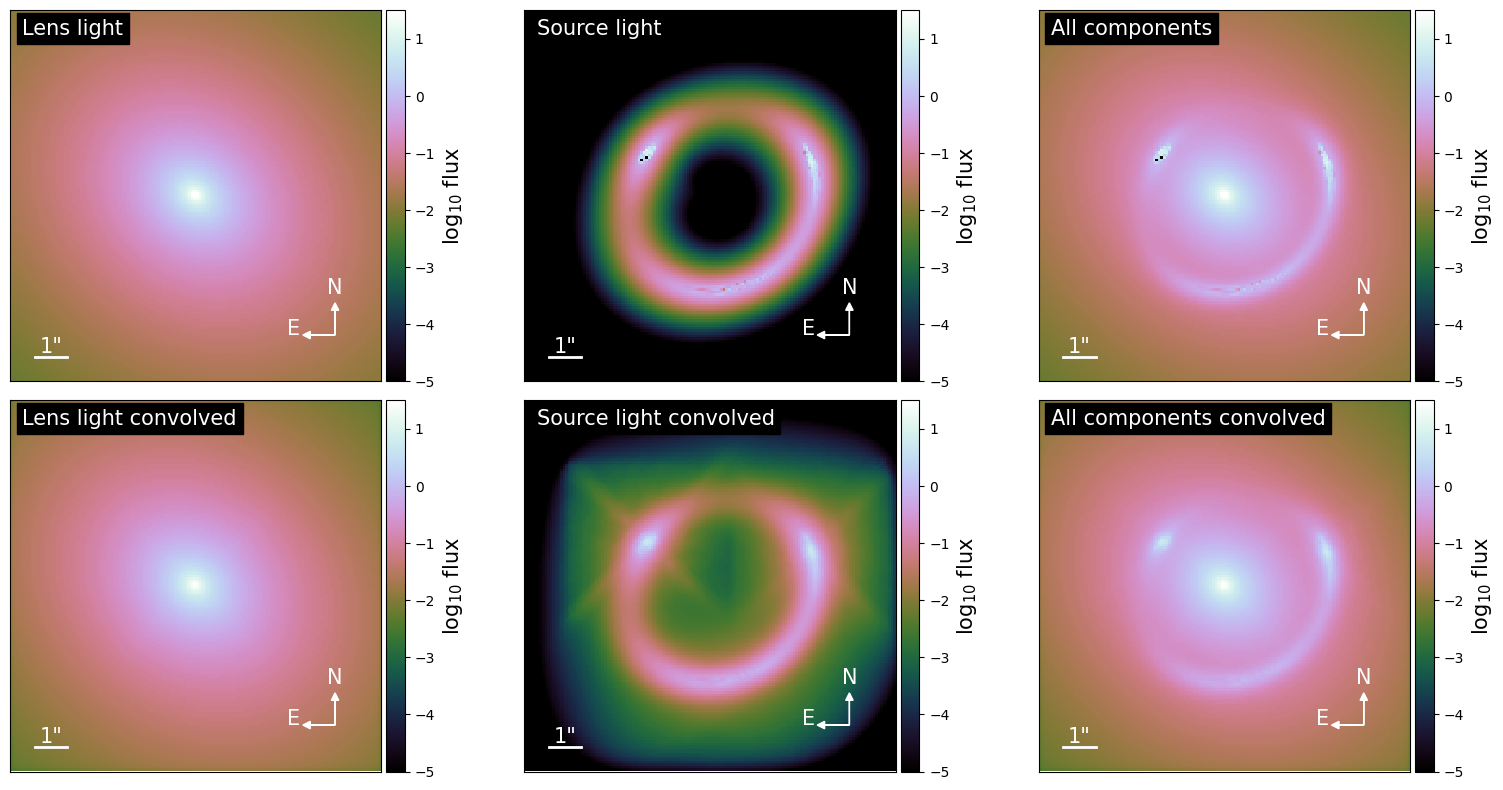

{'kwargs_lens': [{'theta_E': 2.8791944210872153, 'gamma': 1.9123338961332277, 'e1': 0.02141023947880997, 'e2': 0.10338236031338606, 'center_x': 0.10318024299174353, 'center_y': -0.07641337271624558}, {'gamma1': 0.017403457194550807, 'gamma2': -0.014496327790101028, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.2198547073280723, 'n_sersic': 1.0, 'e1': 0.03285873811300954, 'e2': -0.08944386224976253, 'center_x': -0.25720822220379513, 'center_y': -0.21476472100327648}, {'amp': 1, 'n_max': 10, 'beta': 0.030838456648300525, 'center_x': -0.25720822220379513, 'center_y': -0.21476472100327648}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.2494023489847377, 'n_sersic': 4.0, 'e1': 0.02141023947880997, 'e2': 0.10338236031338606, 'center_x': 0.10318024299174353, 'center_y': -0.07641337271624558}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot


model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,
                       with_caustics=True, scale_size=0.5)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.,
                  hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light',
                             lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved',
                             lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light',
                             source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved',
                             source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components',
                             source_add=True, lens_light_add=True,
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved',
                             source_add=True, lens_light_add=True,
                              point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.,
                  hspace=0.05)
plt.show()
print(kwargs_result)

## The MCMC-run:

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


# Define the local path to save the backend file
local_backend_path = 'mcmc_backend.h5'

fitting_kwargs_list_mcmc = [['MCMC', {'n_burn': 0, 'n_run': 1500,
                                      'n_walkers': 100,
                                      'sigma_scale': .1, 'threadCount': 3,
                                      'backend_filename': local_backend_path,
                                      'start_from_backend': True
                                     }]]

fitting_seq_mcmc = FittingSequence(kwargs_data_joint, kwargs_model,
                                   kwargs_constraints,
                                   kwargs_likelihood, kwargs_params)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [7:29:22<00:00, 17.98s/it]


Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 1500
26967.061915397644 time taken for MCMC sampling


## Trace Plot of the MCMC-run:

C:\Users\Zobai\AppData\Local\Temp\ipykernel_12112\4244746617.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 6000, N_walkers: 100, N_params: 15
theta_E_lens0 2.8771 ± 0.0010
gamma_lens0 1.9531 ± 0.0143
gamma1_lens1 0.0172 ± 0.0004
gamma2_lens1 -0.0195 ± 0.0018
R_sersic_source_light0 0.2303 ± 0.0046
e1_source_light0 0.0297 ± 0.0047
e2_source_light0 -0.0860 ± 0.0052
center_x_source_light0 -0.2732 ± 0.0055
center_y_source_light0 -0.2211 ± 0.0024
beta_source_light1 0.0324 ± 0.0006
R_sersic_lens_light0 1.2491 ± 0.0035
e1_lens_light0 0.0214 ± 0.0006
e2_lens_light0 0.1040 ± 0.0008
center_x_lens_light0 0.1031 ± 0.0004
center_y_lens_light0 -0.0765 ± 0.0003


PermissionError: [Errno 13] Permission denied: '/Trace_Plot_DESIJ1018-0121.png'

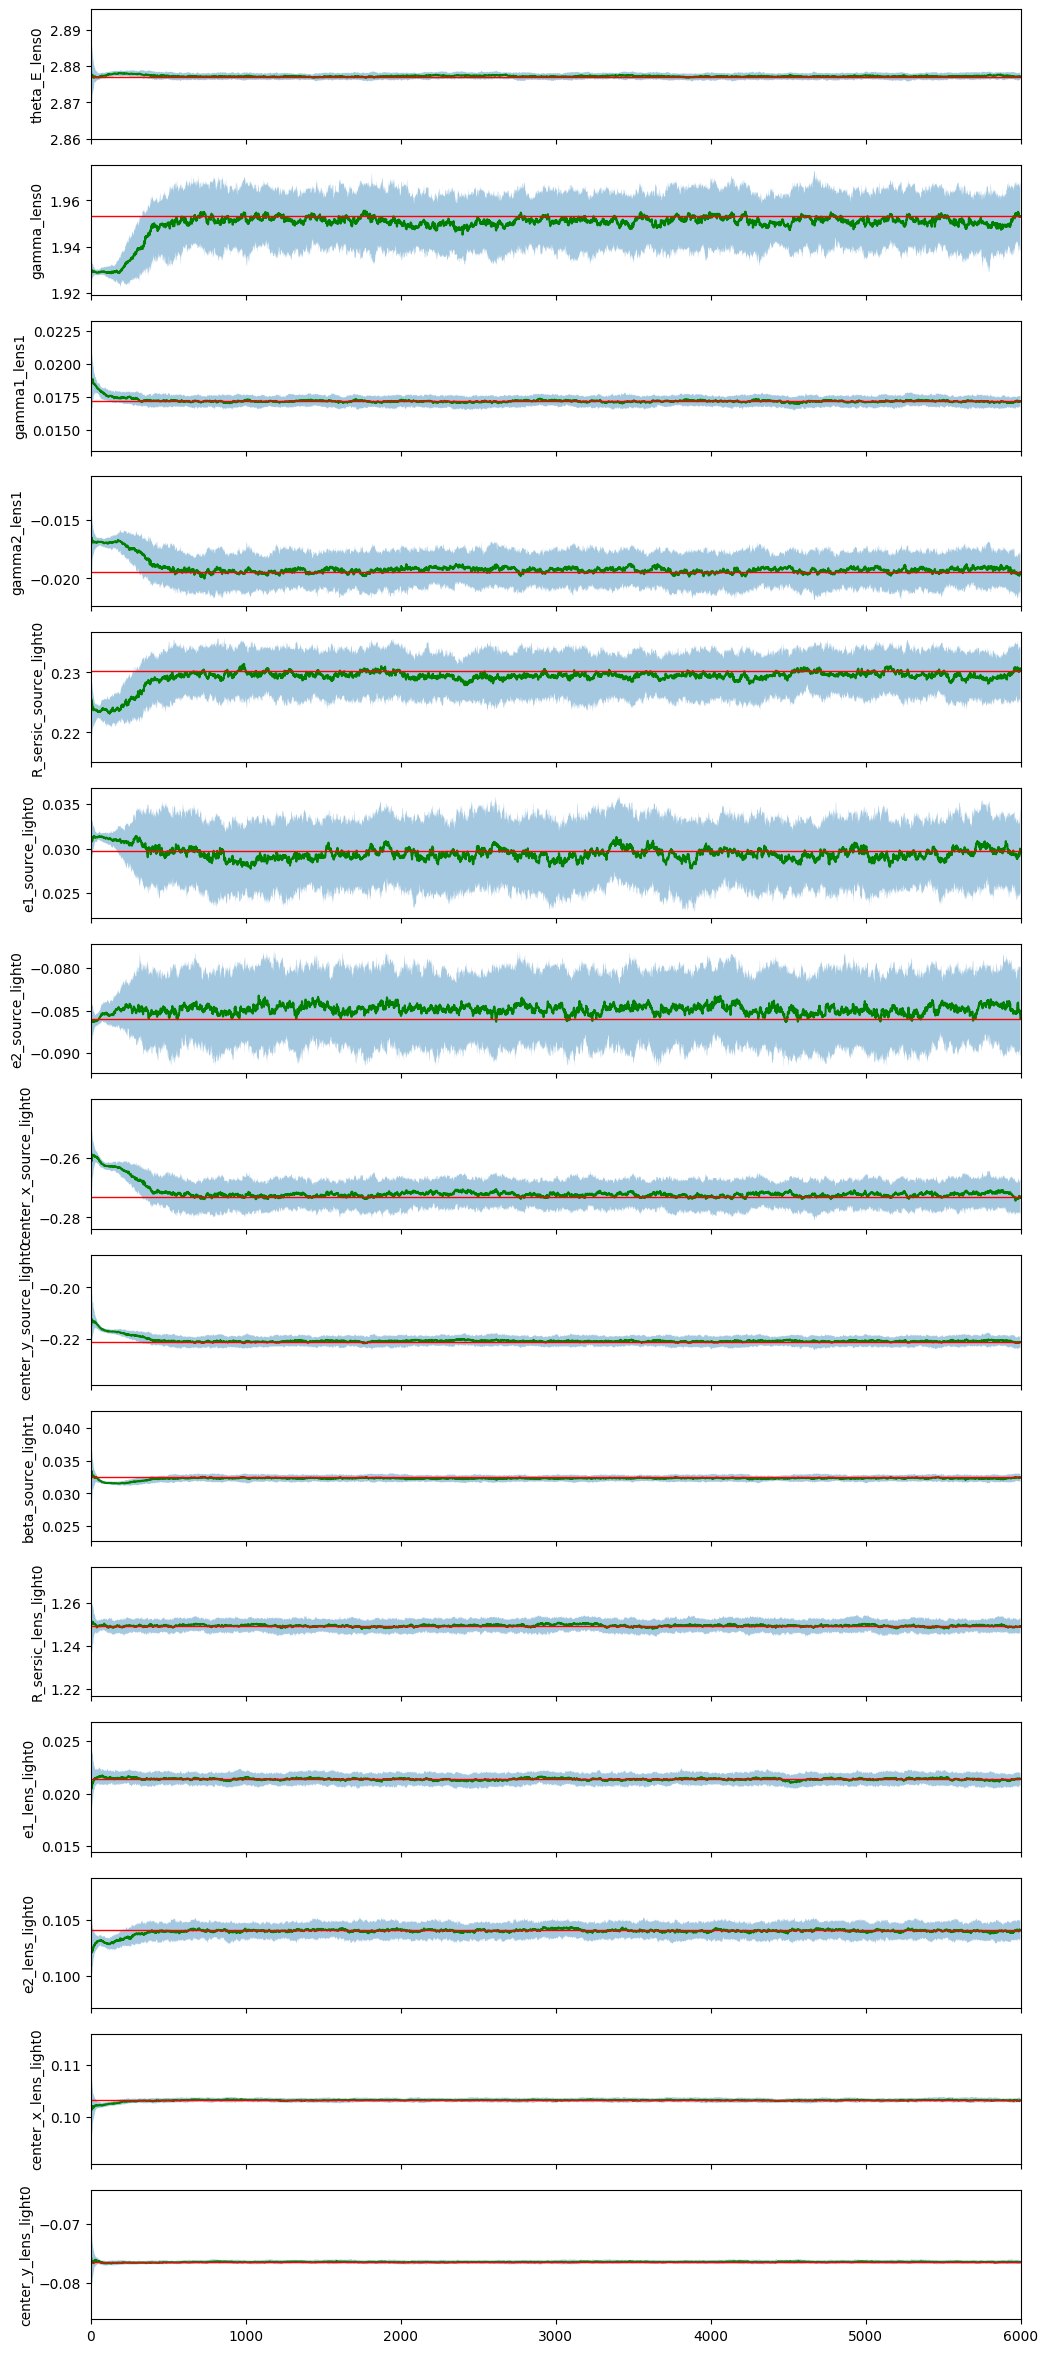

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc)-mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    #n_params = samples_mcmc.shape[1]

    # walker_ratio = 80/50
    # n_walkers = walker_ratio * n_params
    # n_step = int(samples_mcmc.shape[0] / n_walkers)

    #n_walkers = min(7.5 * n_params, samples_mcmc.shape[0])
    #n_step = int(samples_mcmc.shape[0] / n_walkers)

    n_params = samples_mcmc.shape[1]
    n_walkers = 100
    n_step = 6000
    n_burn = 0

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step,
                                                           n_walkers,
                                                           n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order='F')
        chain[:,:,i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1],
                    (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1],
                    (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i],
              '{:.4f} ± {:.4f}'.format(median_pos[i][last-1],
               (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last),
                           q84_pos[i][:last],
                           q16_pos[i][:last],
                           alpha=0.4)

        ax[i].set_ylabel(param_mcmc[i],
                         fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        '''
        plt.savefig("/Trace_Plot_DESIJ1018-0121.png",
                    format="png",
                    bbox_inches="tight")
        '''
        plt.show()


## The Corner Plot:

Number of non-linear parameters in the MCMC process: 15
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Number of evaluations in the MCMC process: 600000
600000
Shape of samples_mcmc_cut: (100000, 15)


C:\Users\Zobai\AppData\Local\Temp\ipykernel_12112\2059091717.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


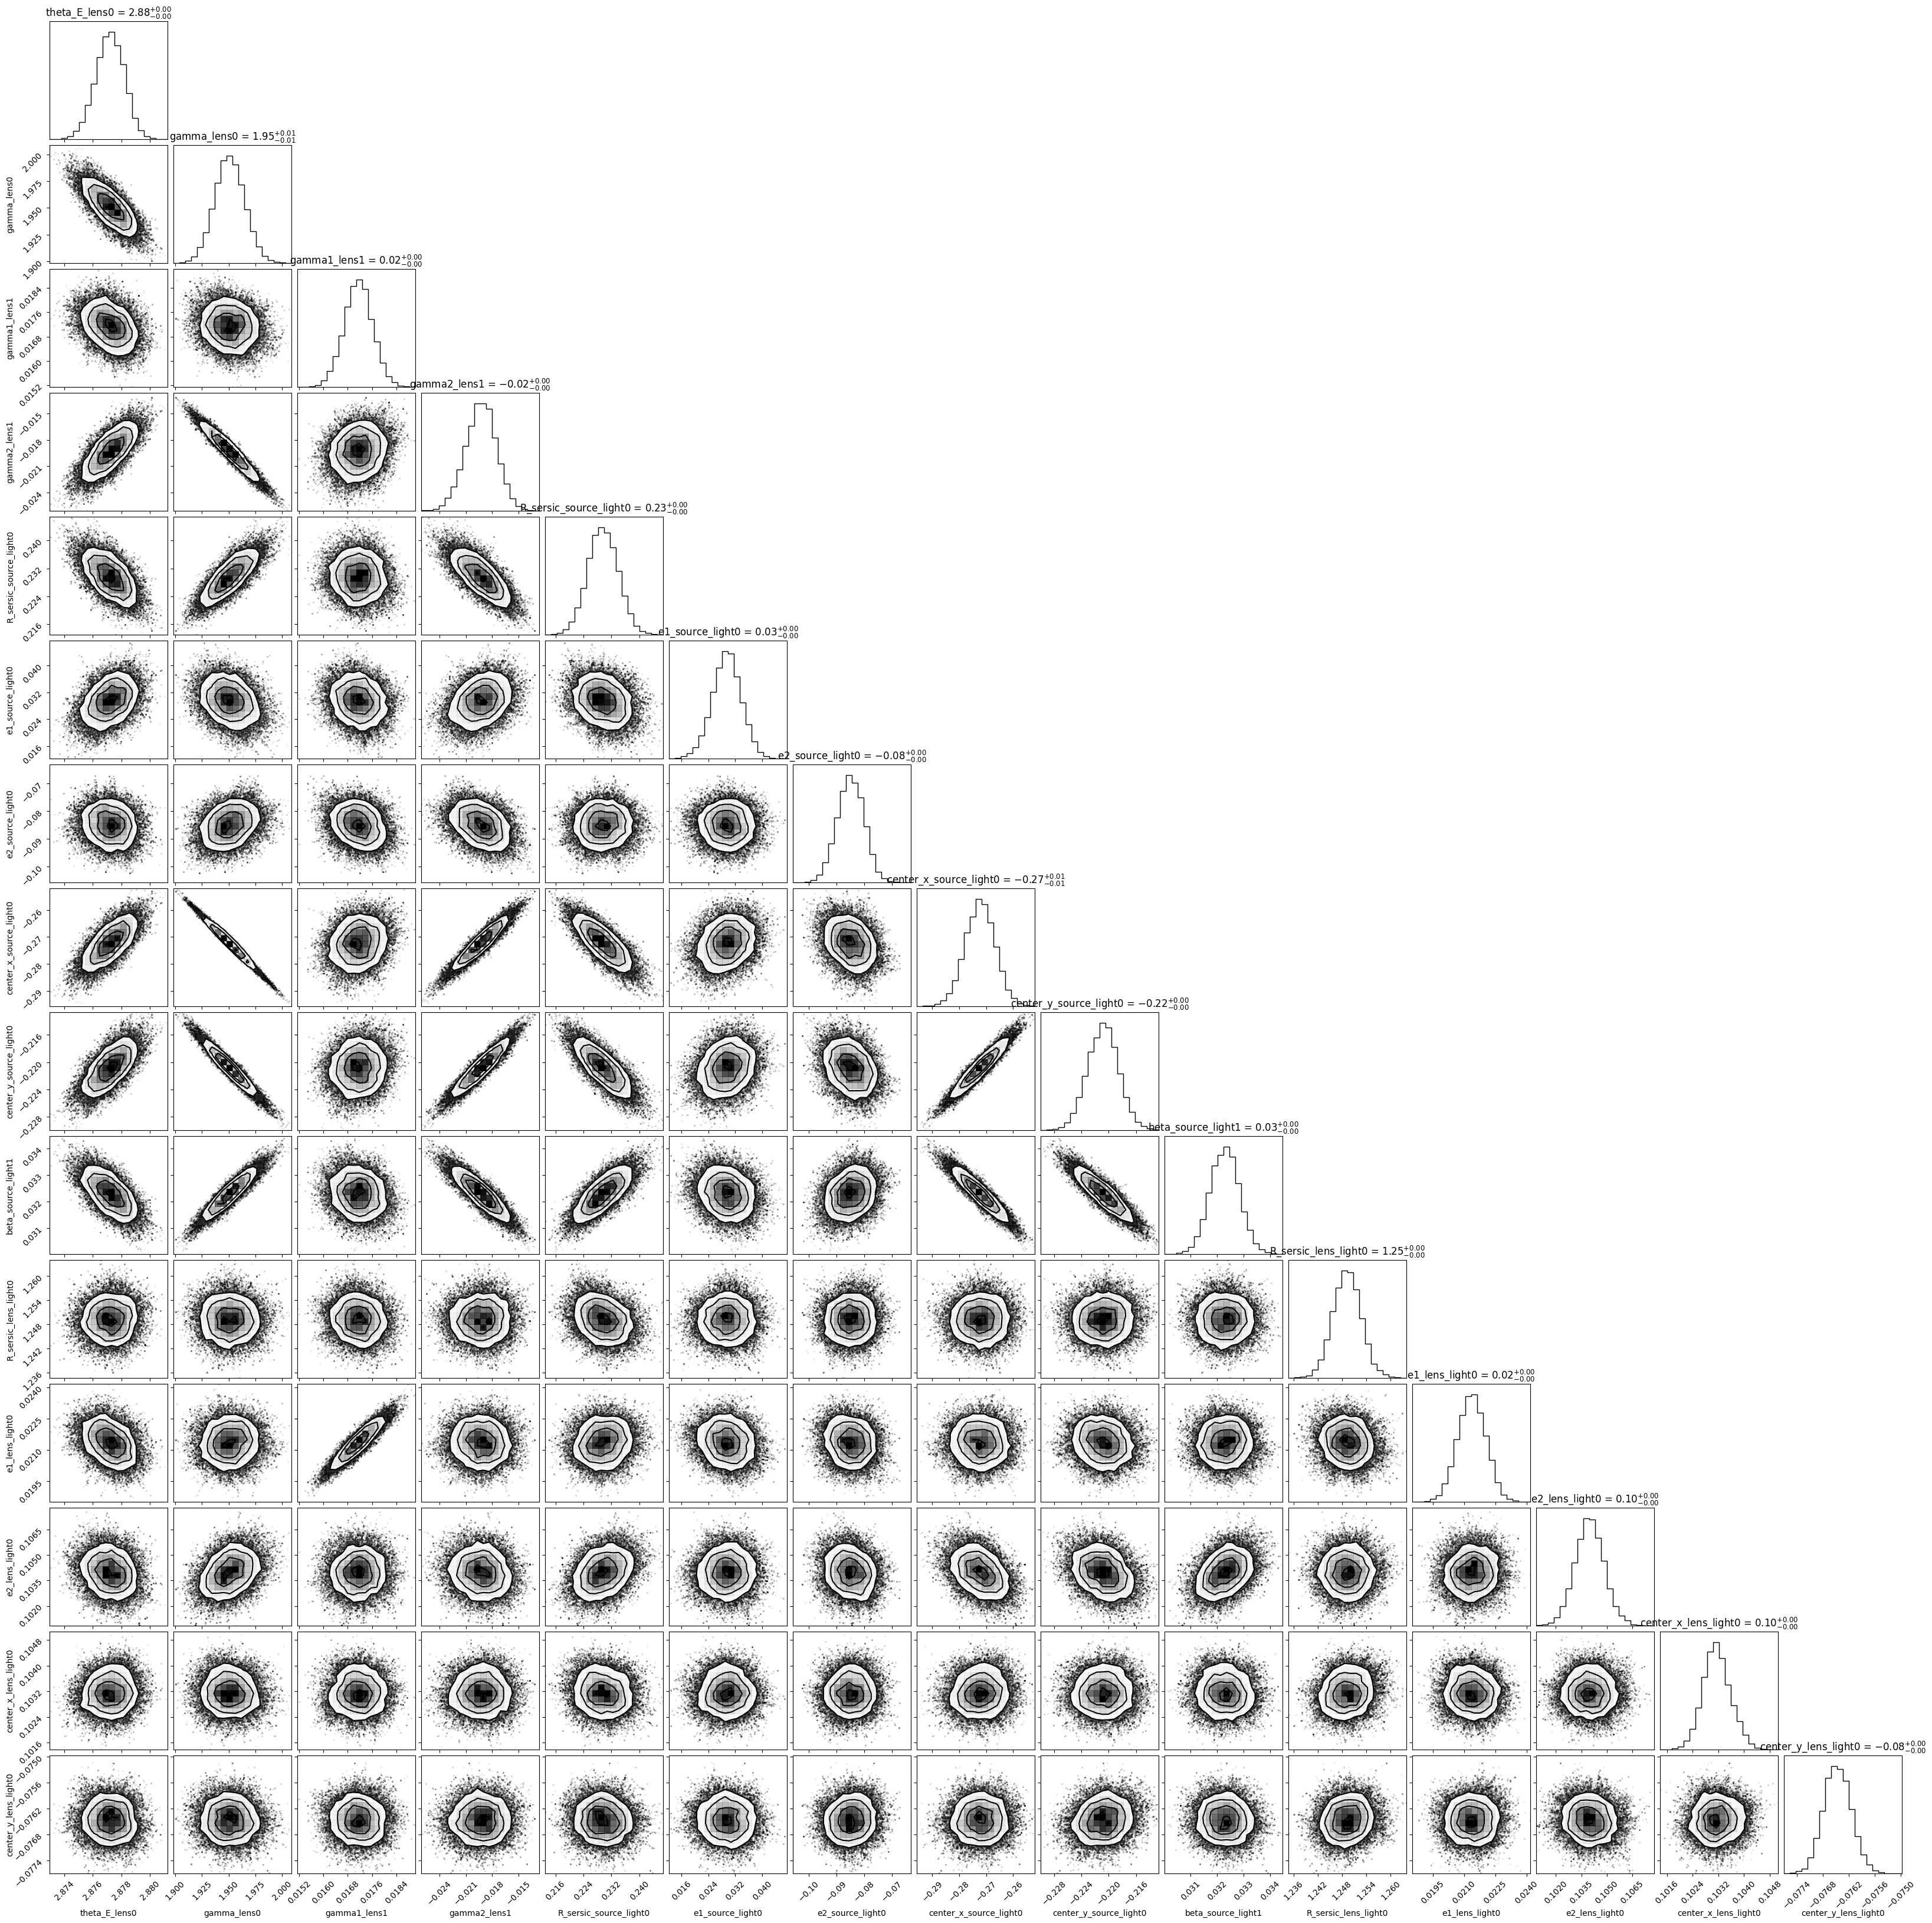

In [ ]:
import corner


if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:",
          len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:",
              np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        samples_mcmc_cut = samples_mcmc[int(n_sample * 5000 / 6000):]
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc,
                                show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")


## Visualize the MCMC fit:

-1.1915985160012417 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1915985160010696


C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\Users\Zobai\AppData\Local\Temp\ipykernel_12112\917958042.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


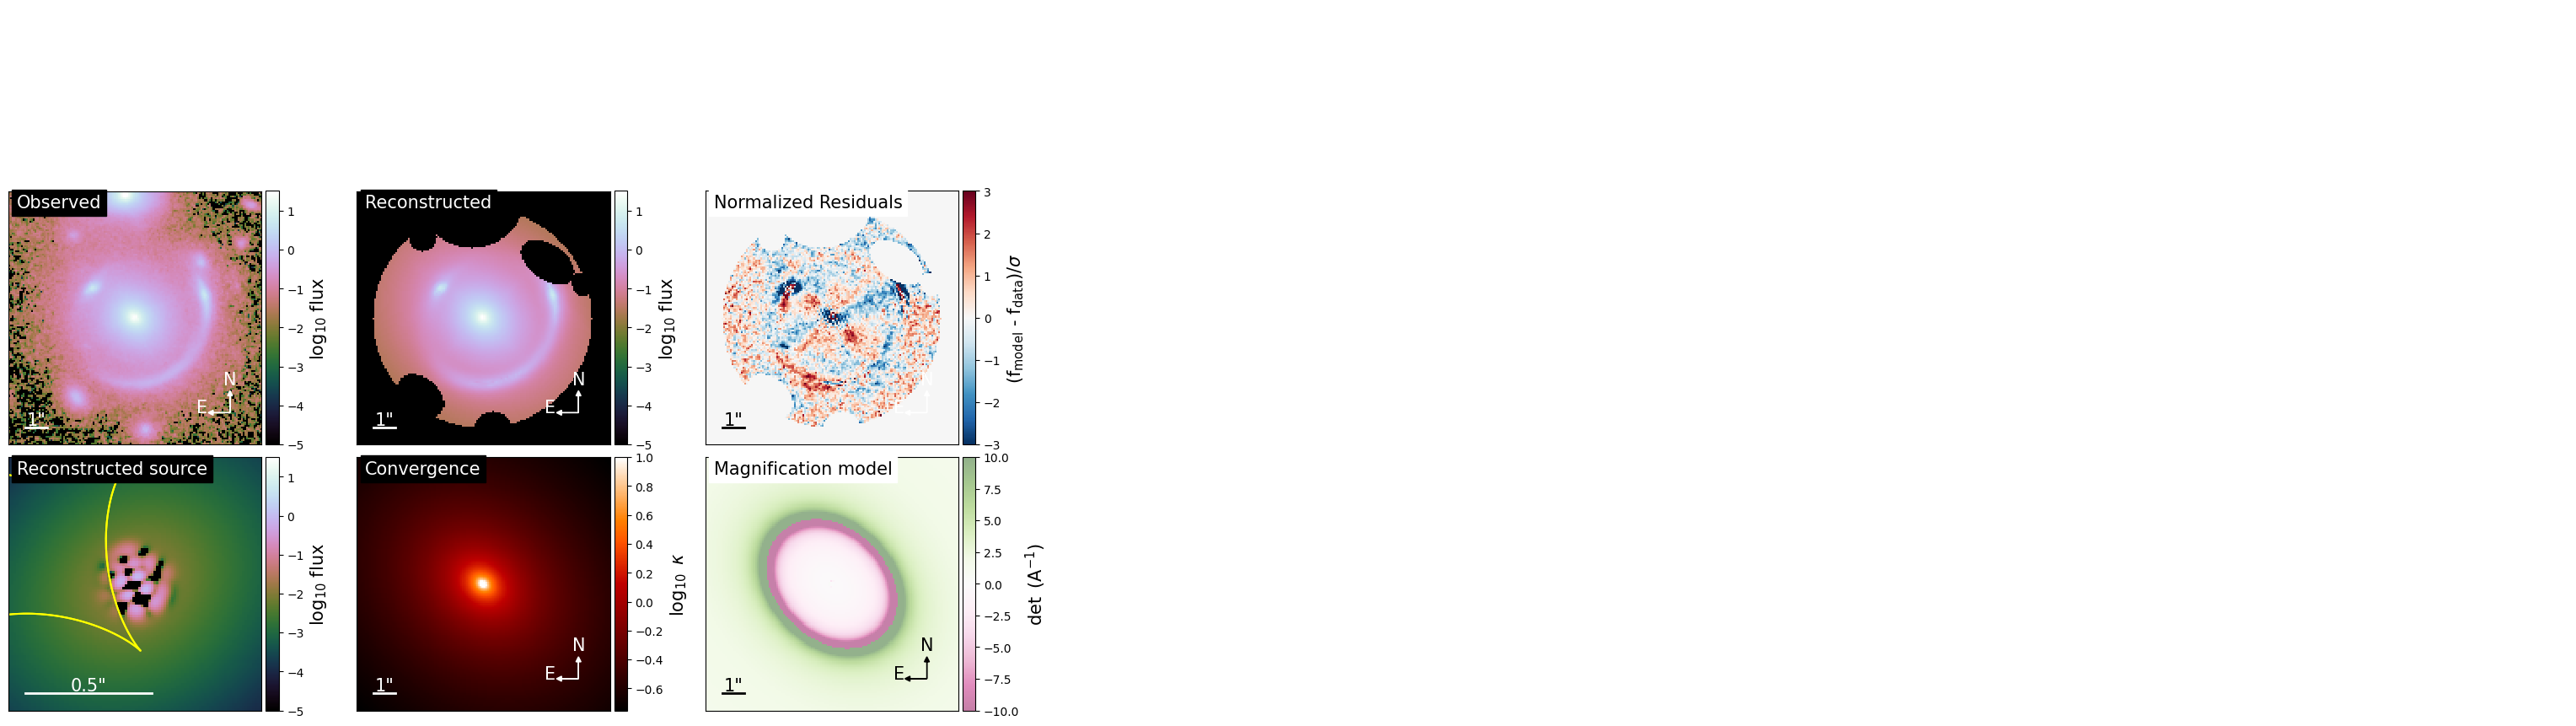

C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


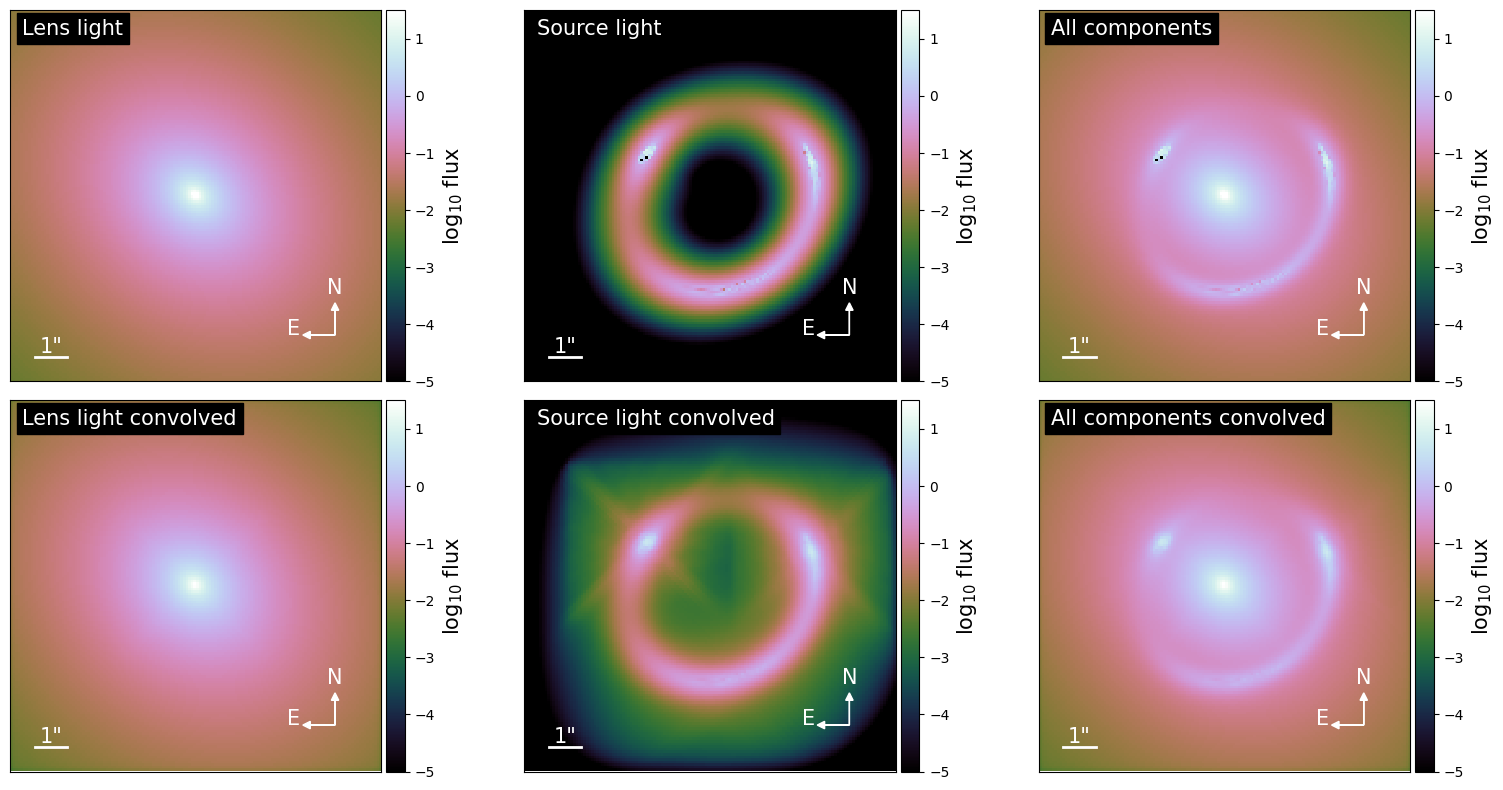

{'kwargs_lens': [{'theta_E': 2.877600264535252, 'gamma': 1.9516982661627786, 'e1': 0.02098643180106076, 'e2': 0.10422870648737867, 'center_x': 0.10322458281018632, 'center_y': -0.07662010125896423}, {'gamma1': 0.016883941092692346, 'gamma2': -0.01933600325596508, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.22976774724004304, 'n_sersic': 1.0, 'e1': 0.030792542934777414, 'e2': -0.08458568786759046, 'center_x': -0.2726182426123534, 'center_y': -0.22114743186286206}, {'amp': 1, 'n_max': 10, 'beta': 0.03242107039838004, 'center_x': -0.2726182426123534, 'center_y': -0.22114743186286206}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.2489840787548387, 'n_sersic': 4.0, 'e1': 0.02098643180106076, 'e2': 0.10422870648737867, 'center_x': 0.10322458281018632, 'center_y': -0.07662010125896423}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot


model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,
                       with_caustics=True, scale_size=0.5)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.,
                  hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light',
                             lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved',
                             lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light',
                             source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved',
                             source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components',
                             source_add=True, lens_light_add=True,
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved',
                             source_add=True, lens_light_add=True,
                              point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.,
                  hspace=0.05)
plt.show()
print(kwargs_result_mcmc)


In [ ]:
import joblib


multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = 6000  # can be not `None` for MCMC

input = [fitting_kwargs_list_mcmc,
         multi_band_list,
         kwargs_model,
         kwargs_constraints,
         kwargs_likelihood,
         kwargs_params,
         init_samples]

output = [kwargs_result_mcmc,
          multi_band_list_out,
          chain_list_mcmc,
          kwargs_fixed_out]

output_path = f'DESIJ1018-0121_mcmc_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)
